In [1]:
import multiprocessing
import os

os.environ["JAX_ENABLE_X64"] = "True"

import joblib
import numpy as np
import jax.numpy as jnp
import pytest
import galsim
import jax_galsim

from deep_field_metadetect.metacal import (
    get_galsim_object_from_ngmix_obs,
    DEFAULT_STEP,
    DEFAULT_SHEARS,
    get_shear_tuple,
    _metacal_op_g1g2_impl,
    _render_psf_and_build_obs,
    get_galsim_object_from_ngmix_obs_nopix,
)
from deep_field_metadetect.jaxify.jax_metacal import (
    get_jax_galsim_object_from_dfmd_obs,
    compute_stepk,
    _jax_metacal_op_g1g2_impl,
    _jax_render_psf_and_build_obs,
    get_jax_galsim_object_from_dfmd_obs_nopix,
)
from deep_field_metadetect.utils import (
    assert_m_c_ok,
    estimate_m_and_c,
    fit_gauss_mom_mcal_res,
    make_simple_sim,
    measure_mcal_shear_quants,
    print_m_c,
)
from deep_field_metadetect.jaxify.observation import (
    ngmix_obs_to_dfmd_obs,
    dfmd_obs_to_ngmix_obs,
)

In [2]:
from functools import partial

In [3]:
import matplotlib.pyplot as plt
import jax
from functools import partial

In [4]:
@partial(jax.jit, static_argnames=["dk", "nxy_psf"])
def jax_get_gauss_reconv_psf_galsim(psf, dk, nxy_psf=53, step=DEFAULT_STEP, flux=1):
    """Gets the target reconvolution PSF for an input PSF object.

    This is taken from galsim/tests/test_metacal.py and assumes the psf is
    centered.

    Parameters
    ----------
    psf : galsim.GSObject
        The input point spread function (PSF) object.
    dk : float
        The Fourier-space pixel scale.
    nxy_psf : int, optional
        The size of the PSF image in pixels (default is 53).
    step : float, optional
        The step size for coordinate grids (default is `DEFAULT_STEP`).
    flux : float, optional
        The total flux of the output PSF (default is 1).

    Returns
    -------
    reconv_psf : JaxGalsim object
        The reconvolution PSF.
    """

    dk = 2 * jnp.pi / (53 * 0.2) / 4.0
    small_kval = 1.0e-2  # Find the k where the given psf hits this kvalue
    smaller_kval = 3.0e-3  # Target PSF will have this kvalue at the same k

    kim = psf.drawKImage(nx=250, ny=250, scale=dk)
    # kim = psf.drawKImage(scale=dk)
    karr_r = kim.real.array
    # Find the smallest r where the kval < small_kval
    nk = karr_r.shape[0]
    kx, ky = jnp.meshgrid(jnp.arange(-nk / 2, nk / 2), jnp.arange(-nk / 2, nk / 2))
    ksq = (kx**2 + ky**2) * dk**2
    ksq_max = jnp.min(jnp.where(karr_r < small_kval * psf.flux, ksq, jnp.inf))

    # We take our target PSF to be the (round) Gaussian that is even smaller at
    # this ksq
    # exp(-0.5 * ksq_max * sigma_sq) = smaller_kval
    sigma_sq = -2.0 * jnp.log(smaller_kval) / ksq_max

    dilation = 1.0 + 2.0 * step
    return (
        jax_galsim.Gaussian(sigma=jnp.sqrt(sigma_sq) * dilation).withFlux(flux),
        kim,
        karr_r,
        ksq_max,
        sigma_sq,
        dilation,
    )


def jax_get_gauss_reconv_psf(dfmd_obs, nxy_psf, dk, step=DEFAULT_STEP):
    """Get the Gaussian reconv PSF for a DFMdetObs."""
    psf = get_jax_galsim_object_from_dfmd_obs_nopix(dfmd_obs.psf, kind="image")
    return jax_get_gauss_reconv_psf_galsim(psf, nxy_psf=nxy_psf, dk=dk, step=step)

In [5]:
def get_gauss_reconv_psf_galsim(psf, step=DEFAULT_STEP, flux=1):
    """Gets the target reconvolution PSF for an input PSF object.

    This is taken from galsim/tests/test_metacal.py and assumes the psf is
    centered.

    Parameters
    ----------
    psf : galsim object
        The PSF.
    flux : float
        The output flux of the PSF. Defaults to 1.

    Returns
    -------
    reconv_psf : galsim object
        The reconvolution PSF.
    """
    dk = 2 * np.pi / (53 * 0.2) / 4.0

    small_kval = 1.0e-2  # Find the k where the given psf hits this kvalue
    smaller_kval = 3.0e-3  # Target PSF will have this kvalue at the same k

    kim = psf.drawKImage(nx=250, ny=250, scale=dk)
    karr_r = kim.real.array
    # Find the smallest r where the kval < small_kval
    nk = karr_r.shape[0]
    kx, ky = np.meshgrid(np.arange(-nk / 2, nk / 2), np.arange(-nk / 2, nk / 2))
    ksq = (kx**2 + ky**2) * dk**2
    ksq_max = np.min(ksq[karr_r < small_kval * psf.flux])

    # We take our target PSF to be the (round) Gaussian that is even smaller at
    # this ksq
    # exp(-0.5 * ksq_max * sigma_sq) = smaller_kval
    sigma_sq = -2.0 * np.log(smaller_kval) / ksq_max

    dilation = 1.0 + 2.0 * step
    return (
        galsim.Gaussian(sigma=np.sqrt(sigma_sq) * dilation).withFlux(flux),
        kim,
        karr_r,
        ksq_max,
        sigma_sq,
        dilation,
    )


def get_gauss_reconv_psf(obs, step=DEFAULT_STEP):
    """Get the Gaussian reconv PSF for an ngmix obs."""
    psf = get_galsim_object_from_ngmix_obs_nopix(obs.psf, kind="image")
    return get_gauss_reconv_psf_galsim(psf, step=step)

In [112]:
def jax_metacal_op_shears(
    dfmd_obs,
    nxy_psf=53,
    reconv_psf=None,
    shears=None,
    step=DEFAULT_STEP,
    scale=0.2,
):
    """Run metacal on an dfmd observation."""
    if shears is None:
        shears = DEFAULT_SHEARS

    dk = compute_stepk(pixel_scale=scale, image_size=nxy_psf)
    if reconv_psf is None:
        reconv_psf, kim, karr_r, ksq_max, sigma_sq, dilation = jax_get_gauss_reconv_psf(
            dfmd_obs,
            dk=dk,
            nxy_psf=nxy_psf,
            step=step,
        )

    wcs = dfmd_obs.aft._local_wcs
    image = get_jax_galsim_object_from_dfmd_obs(dfmd_obs, kind="image")
    # we rotate by 90 degrees on the way in and then _metacal_op_g1g2_impl
    # rotates back after deconv and shearing
    noise = get_jax_galsim_object_from_dfmd_obs(dfmd_obs, kind="noise", rot90=1)
    psf = get_jax_galsim_object_from_dfmd_obs(dfmd_obs.psf, kind="image")

    # psf=psf.withGSParams(
    #     minimum_fft_size=100 * 4,
    #     maximum_fft_size=100 * 4,
    # )
    psf_inv = jax_galsim.Deconvolve(
        psf,
        gsparams=jax_galsim.GSParams(minimum_fft_size=32 * 8, maximum_fft_size=32 * 8),
        propagate_gsparams=False,
    )

    mcal_res = {}
    for shear in shears:
        g1, g2 = get_shear_tuple(shear, step)

        mcal_image = _jax_metacal_op_g1g2_impl(
            wcs=wcs,
            image=image,
            noise=noise,
            psf_inv=psf_inv,
            dims=dfmd_obs.image.shape,
            reconv_psf=reconv_psf,
            g1=g1,
            g2=g2,
        )

        mcal_res[shear] = _jax_render_psf_and_build_obs(
            mcal_image,
            dfmd_obs,
            reconv_psf,
            nxy_psf=nxy_psf,
            weight_fac=0.5,
        )
    return (
        mcal_res,
        image,
        noise,
        psf,
        psf_inv,
        mcal_image,
        mcal_res,
        reconv_psf,
        kim,
        karr_r,
        ksq_max,
        sigma_sq,
        dilation,
    )

In [113]:
def metacal_op_shears(obs, reconv_psf=None, shears=None, step=DEFAULT_STEP):
    """Run metacal on an ngmix observation."""
    if shears is None:
        shears = DEFAULT_SHEARS

    if reconv_psf is None:
        reconv_psf, kim, karr_r, ksq_max, sigma_sq, dilation = get_gauss_reconv_psf(
            obs, step=step
        )

    wcs = obs.jacobian.get_galsim_wcs()
    image = get_galsim_object_from_ngmix_obs(obs, kind="image")
    # we rotate by 90 degrees on the way in and then _metacal_op_g1g2_impl
    # rotates back after deconv and shearing
    noise = get_galsim_object_from_ngmix_obs(obs, kind="noise", rot90=1)
    psf = get_galsim_object_from_ngmix_obs(obs.psf, kind="image")
    psf_inv = galsim.Deconvolve(psf)

    mcal_res = {}
    for shear in shears:
        g1, g2 = get_shear_tuple(shear, step)
        mcal_image = _metacal_op_g1g2_impl(
            wcs=wcs,
            image=image,
            noise=noise,
            psf_inv=psf_inv,
            dims=obs.image.shape,
            reconv_psf=reconv_psf,
            g1=g1,
            g2=g2,
        )
        mcal_res[shear] = _render_psf_and_build_obs(
            mcal_image, obs, reconv_psf, weight_fac=0.5
        )
    return (
        mcal_res,
        image,
        noise,
        psf,
        psf_inv,
        mcal_image,
        mcal_res,
        reconv_psf,
        kim,
        karr_r,
        ksq_max,
        sigma_sq,
        dilation,
    )

In [114]:
def _run_single_sim_pair_jax_and_ngmix(seed, s2n):
    nxy = 53
    nxy_psf = 53
    scale = 0.2
    obs_plus, *_ = make_simple_sim(
        seed=seed,
        g1=0.02,
        g2=0.0,
        s2n=s2n,
        dim=nxy,
        dim_psf=nxy_psf,
        scale=scale,
        deep_noise_fac=1.0 / np.sqrt(10),
        deep_psf_fac=1.0,
        return_dfmd_obs=False,
    )

    (
        mcal_res_ngmix,
        image_ngmix,
        noise_ngmix,
        psf_ngmix,
        psf_inv_ngmix,
        mcal_image_ngmix,
        mcal_res_ngmix,
        reconv_psf_ngmix,
        kim_ngmix,
        karr_r_ngmix,
        ksq_max_ngmix,
        sigma_sq_ngmix,
        dilation_ngmix,
    ) = metacal_op_shears(obs_plus)

    res_p_ngmix = fit_gauss_mom_mcal_res(mcal_res_ngmix)
    res_p_ngmix = measure_mcal_shear_quants(res_p_ngmix)
    old_obs_plus = obs_plus.copy()
    obs_plus = ngmix_obs_to_dfmd_obs(obs_plus)

    (
        mcal_res,
        image,
        noise,
        psf,
        psf_inv,
        mcal_image,
        mcal_res,
        reconv_psf,
        kim,
        karr_r,
        ksq_max,
        sigma_sq,
        dilation,
    ) = jax_metacal_op_shears(
        obs_plus,
        nxy_psf=nxy_psf,
        scale=scale,
    )
    res_p = fit_gauss_mom_mcal_res(mcal_res)
    res_p = measure_mcal_shear_quants(res_p)

    obs_minus, *_ = make_simple_sim(
        seed=seed,
        g1=-0.02,
        g2=0.0,
        s2n=s2n,
        dim=nxy,
        dim_psf=nxy_psf,
        scale=scale,
        deep_noise_fac=1.0 / np.sqrt(10),
        deep_psf_fac=1.0,
        return_dfmd_obs=False,
    )

    (
        mcal_res_ngmix,
        image_ngmix,
        noise_ngmix,
        psf_ngmix,
        psf_inv_ngmix,
        mcal_image_ngmix,
        mcal_res_ngmix,
        reconv_psf_ngmix,
        kim_ngmix,
        karr_r_ngmix,
        ksq_max_ngmix,
        sigma_sq_ngmix,
        dilation_ngmix,
    ) = metacal_op_shears(obs_minus)
    res_m_ngmix = fit_gauss_mom_mcal_res(mcal_res_ngmix)
    res_m_ngmix = measure_mcal_shear_quants(res_m_ngmix)

    obs_minus = ngmix_obs_to_dfmd_obs(obs_minus)
    (
        mcal_res,
        image,
        noise,
        psf,
        psf_inv,
        mcal_image,
        mcal_res,
        reconv_psf,
        kim,
        karr_r,
        ksq_max,
        sigma_sq,
        dilation,
    ) = jax_metacal_op_shears(
        obs_minus,
        nxy_psf=nxy_psf,
        scale=scale,
    )
    res_m = fit_gauss_mom_mcal_res(mcal_res)
    res_m = measure_mcal_shear_quants(res_m)

    return (
        (res_p, res_m),
        (res_p_ngmix, res_m_ngmix),
        (mcal_res, image, noise, psf, psf_inv, mcal_image, mcal_res, reconv_psf),
        (
            mcal_res_ngmix,
            image_ngmix,
            noise_ngmix,
            psf_ngmix,
            psf_inv_ngmix,
            mcal_image_ngmix,
            mcal_res_ngmix,
            reconv_psf_ngmix,
        ),
        (old_obs_plus, obs_plus),
        (kim, karr_r, ksq_max, sigma_sq, dilation),
        (kim_ngmix, karr_r_ngmix, ksq_max_ngmix, sigma_sq_ngmix, dilation_ngmix),
    )

In [115]:
(
    (res_p, res_m),
    (res_p_ngmix, res_m_ngmix),
    jax_intermediates,
    numpy_intermediates,
    obs,
    jax_reconv,
    numpy_reconv,
) = _run_single_sim_pair_jax_and_ngmix(10, 1e8)

In [116]:
obs[0].psf.jacobian

ngmix.Jacobian(row=26.0, col=26.0, dvdrow=0.2, dvdcol=0.0, dudrow=0.0, dudcol=0.2)

In [117]:
obs[1].psf.aft

galsim.AffineTransform(0.2, 0.0, 0.0, 0.2, origin=galsim.PositionD(x=27.0, y=27.0), world_origin=galsim.PositionD(x=0.0, y=0.0))

In [118]:
res_p_ngmix

array([(0.01308229, 0.00436202, 0.00872346, 0.00436275, -0.00436436, -1.1700455e-08, 1., 1., 1., 1., 1., 1.)],
      dtype=[('wmom_tot_g1p', '<f8'), ('wmom_tot_g1m', '<f8'), ('wmom_tot_g1', '<f8'), ('wmom_tot_g2p', '<f8'), ('wmom_tot_g2m', '<f8'), ('wmom_tot_g2', '<f8'), ('wmom_num_g1p', '<f8'), ('wmom_num_g1m', '<f8'), ('wmom_num_g1', '<f8'), ('wmom_num_g2p', '<f8'), ('wmom_num_g2m', '<f8'), ('wmom_num_g2', '<f8')])

In [119]:
res_p

array([(0.01308222, 0.00436208, 0.00872347, 0.00436276, -0.00436437, -1.54025923e-08, 1., 1., 1., 1., 1., 1.)],
      dtype=[('wmom_tot_g1p', '<f8'), ('wmom_tot_g1m', '<f8'), ('wmom_tot_g1', '<f8'), ('wmom_tot_g2p', '<f8'), ('wmom_tot_g2m', '<f8'), ('wmom_tot_g2', '<f8'), ('wmom_num_g1p', '<f8'), ('wmom_num_g1m', '<f8'), ('wmom_num_g1', '<f8'), ('wmom_num_g2p', '<f8'), ('wmom_num_g2m', '<f8'), ('wmom_num_g2', '<f8')])

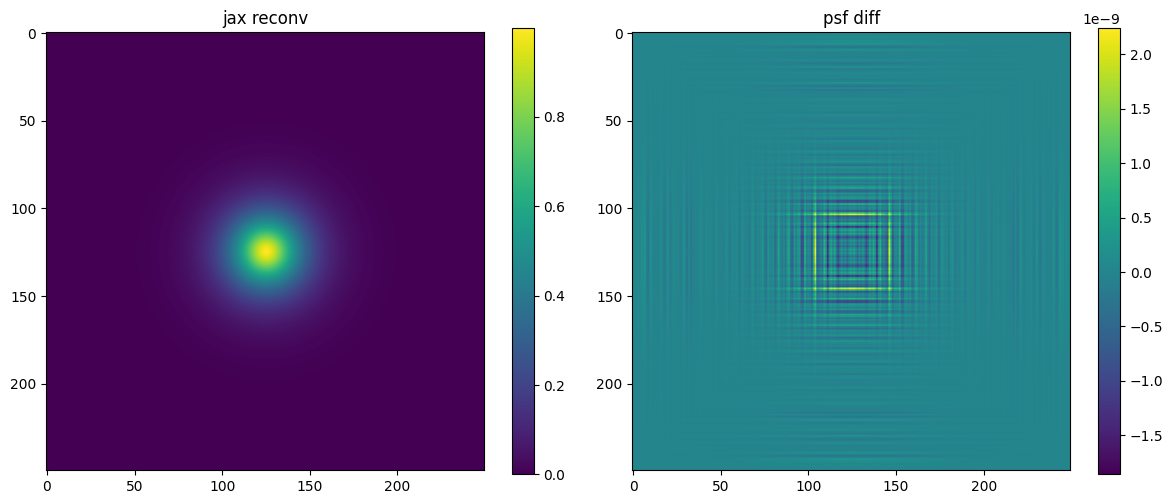

In [120]:
# Compare reconv psf

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_reconv[1])
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("jax reconv")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(jax_reconv[1] - numpy_reconv[1])
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("psf diff")

plt.tight_layout()
plt.show()

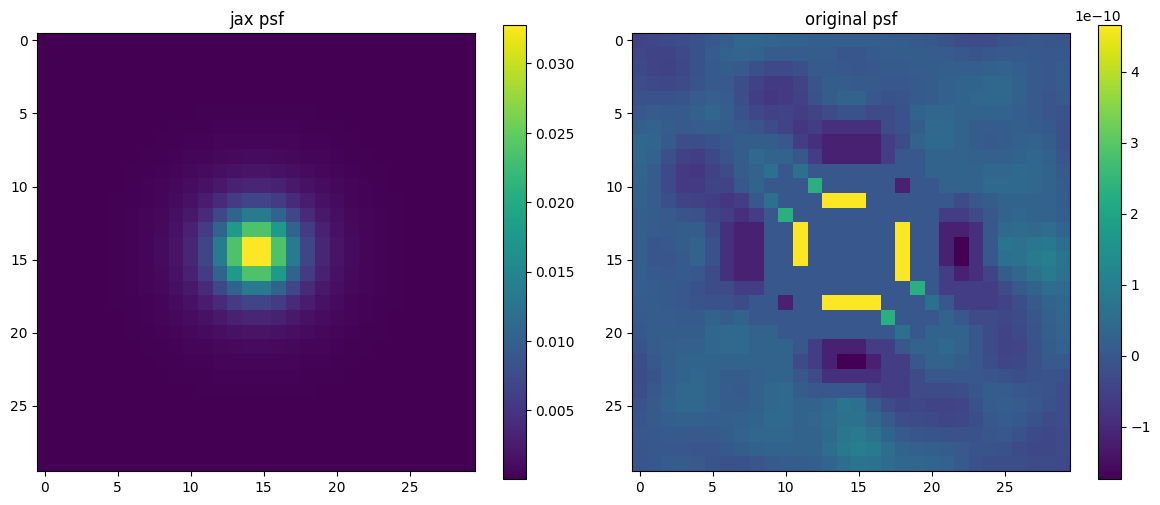

In [121]:
# compare noise
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_intermediates[3].drawImage(scale=0.2, nx=30, ny=30).array)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("jax psf")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(
    jax_intermediates[3].drawImage(scale=0.2, nx=30, ny=30).array
    - numpy_intermediates[3].drawImage(scale=0.2, nx=30, ny=30).array
)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("original psf")

plt.tight_layout()
plt.show()

In [122]:
jax_intermediates[1]

galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-26, xmax=26, ymin=-26, ymax=26), array=
array([[3.40693077e-07, 3.75396894e-07, 4.12530881e-07, ...,
        4.36540006e-07, 3.95687437e-07, 3.57840207e-07],
       [3.74174135e-07, 4.14708438e-07, 4.59189465e-07, ...,
        4.85879298e-07, 4.37742131e-07, 3.94686253e-07],
       [4.10724994e-07, 4.58070645e-07, 5.09943675e-07, ...,
        5.39575865e-07, 4.85326098e-07, 4.36264770e-07],
       ...,
       [3.75209055e-07, 4.15854430e-07, 4.61532352e-07, ...,
        4.87706643e-07, 4.38426099e-07, 3.96964339e-07],
       [3.41272482e-07, 3.76544705e-07, 4.15455588e-07, ...,
        4.38453696e-07, 3.97309748e-07, 3.60540383e-07],
       [3.09538933e-07, 3.41027146e-07, 3.74926401e-07, ...,
        3.94865936e-07, 3.58036459e-07, 3.26984775e-07]]), wcs=galsim.PixelScale(1.0)), galsim.Lanczos(15, True, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), galsim.Quintic(gspar

In [123]:
numpy_intermediates[1]

galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-26, xmax=26, ymin=-26, ymax=26), array=
array([[3.40693077e-07, 3.75396894e-07, 4.12530881e-07, ...,
        4.36540006e-07, 3.95687437e-07, 3.57840207e-07],
       [3.74174135e-07, 4.14708438e-07, 4.59189465e-07, ...,
        4.85879298e-07, 4.37742131e-07, 3.94686253e-07],
       [4.10724994e-07, 4.58070645e-07, 5.09943675e-07, ...,
        5.39575865e-07, 4.85326098e-07, 4.36264770e-07],
       ...,
       [3.75209055e-07, 4.15854430e-07, 4.61532352e-07, ...,
        4.87706643e-07, 4.38426099e-07, 3.96964339e-07],
       [3.41272482e-07, 3.76544705e-07, 4.15455588e-07, ...,
        4.38453696e-07, 3.97309748e-07, 3.60540383e-07],
       [3.09538933e-07, 3.41027146e-07, 3.74926401e-07, ...,
        3.94865936e-07, 3.58036459e-07, 3.26984775e-07]]), wcs=galsim.JacobianWCS(0.2, 0.0, 0.0, 0.2)), galsim.Lanczos(15, True, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), gals

In [124]:
jax_intermediates[4]

galsim.Deconvolution(galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-26, xmax=26, ymin=-26, ymax=26), array=
array([[3.12316985e-07, 3.42946777e-07, 3.76746215e-07, ...,
        3.76746215e-07, 3.42946777e-07, 3.12316985e-07],
       [3.42946777e-07, 3.78225479e-07, 4.17004060e-07, ...,
        4.17004060e-07, 3.78225479e-07, 3.42946777e-07],
       [3.76746215e-07, 4.17004060e-07, 4.61860793e-07, ...,
        4.61860793e-07, 4.17004060e-07, 3.76746215e-07],
       ...,
       [3.76746215e-07, 4.17004060e-07, 4.61860793e-07, ...,
        4.61860793e-07, 4.17004060e-07, 3.76746215e-07],
       [3.42946777e-07, 3.78225479e-07, 4.17004060e-07, ...,
        4.17004060e-07, 3.78225479e-07, 3.42946777e-07],
       [3.12316985e-07, 3.42946777e-07, 3.76746215e-07, ...,
        3.76746215e-07, 3.42946777e-07, 3.12316985e-07]]), wcs=galsim.PixelScale(1.0)), galsim.Lanczos(15, True, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)),

In [125]:
numpy_intermediates[4]

galsim.Deconvolution(galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-26, xmax=26, ymin=-26, ymax=26), array=
array([[3.12316985e-07, 3.42946777e-07, 3.76746215e-07, ...,
        3.76746215e-07, 3.42946777e-07, 3.12316985e-07],
       [3.42946777e-07, 3.78225479e-07, 4.17004060e-07, ...,
        4.17004060e-07, 3.78225479e-07, 3.42946777e-07],
       [3.76746215e-07, 4.17004060e-07, 4.61860793e-07, ...,
        4.61860793e-07, 4.17004060e-07, 3.76746215e-07],
       ...,
       [3.76746215e-07, 4.17004060e-07, 4.61860793e-07, ...,
        4.61860793e-07, 4.17004060e-07, 3.76746215e-07],
       [3.42946777e-07, 3.78225479e-07, 4.17004060e-07, ...,
        4.17004060e-07, 3.78225479e-07, 3.42946777e-07],
       [3.12316985e-07, 3.42946777e-07, 3.76746215e-07, ...,
        3.76746215e-07, 3.42946777e-07, 3.12316985e-07]]), wcs=galsim.JacobianWCS(0.2, 0.0, 0.0, 0.2)), galsim.Lanczos(15, True, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-0

# psf_inv for Deconvolution

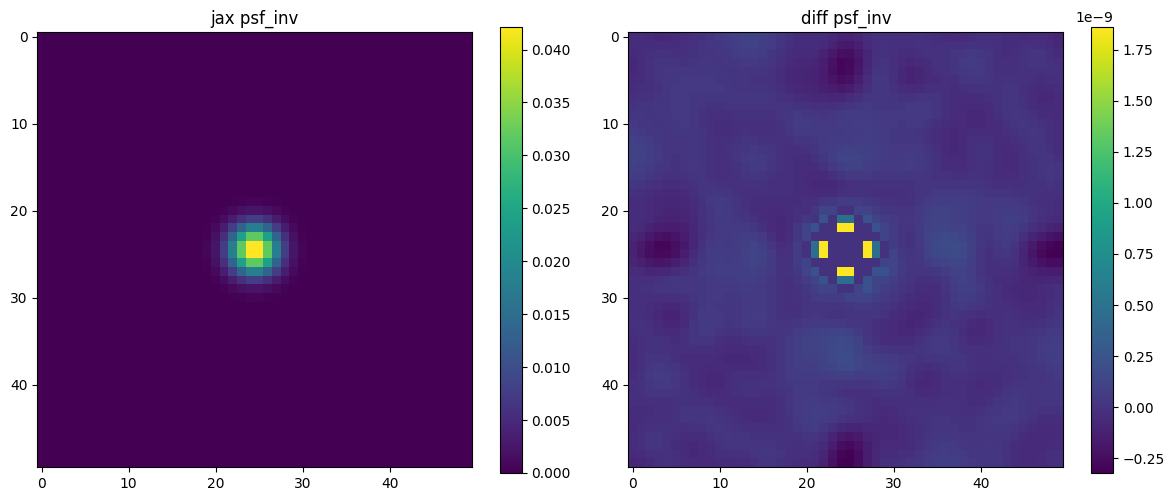

In [93]:
# compare PSF_INV
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_intermediates[7].drawImage(scale=0.2, nx=50, ny=50).array)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("jax psf_inv")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(
    jax_intermediates[7].drawImage(scale=0.2, nx=50, ny=50).array
    - numpy_intermediates[7].drawImage(scale=0.2, nx=50, ny=50).array
)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("diff psf_inv")

plt.tight_layout()
plt.show()

# Reconvolution PSF

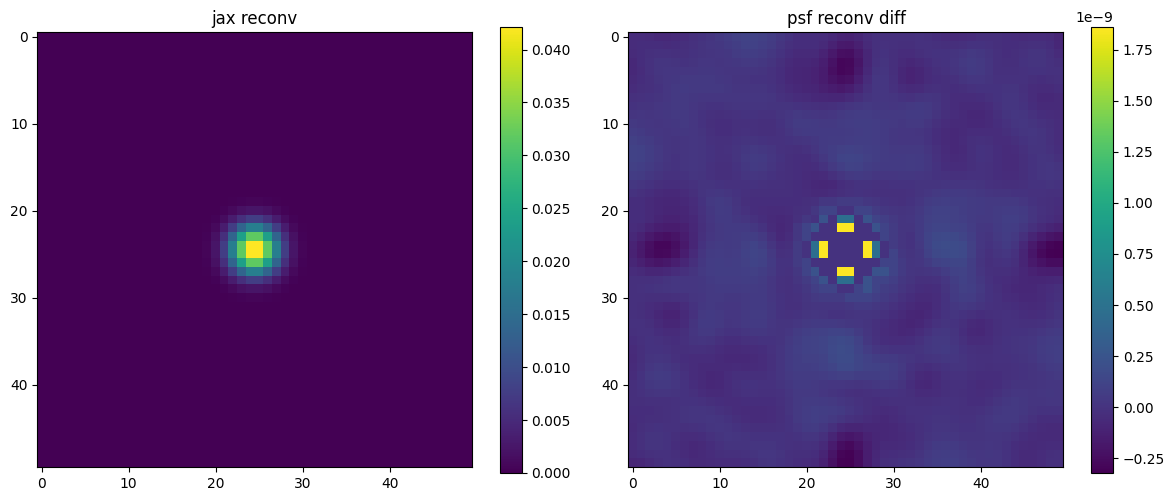

In [94]:
# compare PSF_INV
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_intermediates[7].drawImage(scale=0.2, nx=50, ny=50).array)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("jax reconv")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(
    jax_intermediates[7].drawImage(scale=0.2, nx=50, ny=50).array
    - numpy_intermediates[7].drawImage(scale=0.2, nx=50, ny=50).array
)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("psf reconv diff")

plt.tight_layout()
plt.show()

# Compare PSF array

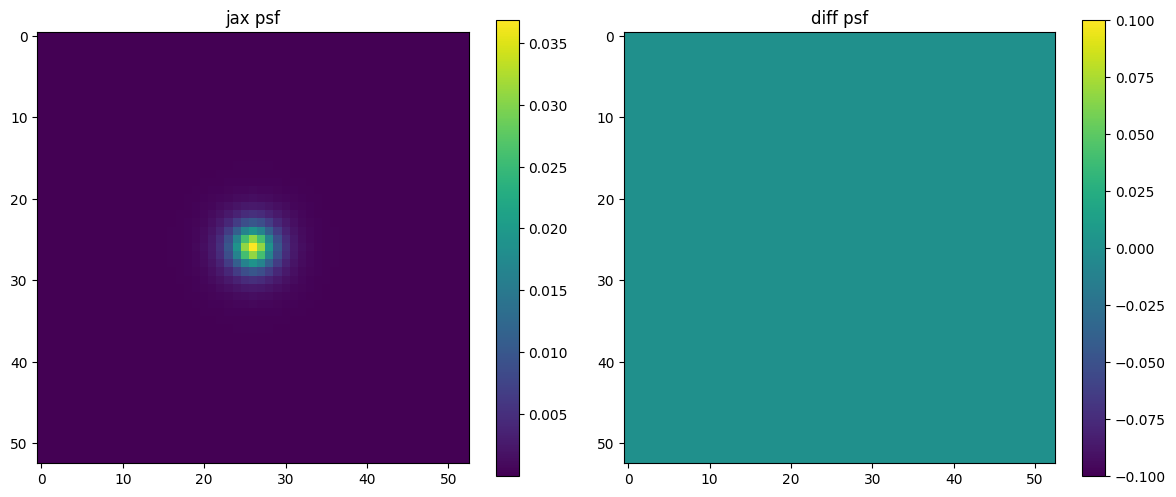

In [95]:
# Compare PSF array
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(
    get_jax_galsim_object_from_dfmd_obs(obs[1].psf, kind="image").image.array
)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("jax psf")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(
    get_jax_galsim_object_from_dfmd_obs(obs[1].psf, kind="image").image.array
    - get_galsim_object_from_ngmix_obs(obs[0].psf, kind="image").image.array
)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("diff psf")

plt.tight_layout()

# galimage + noise (mcal_image)

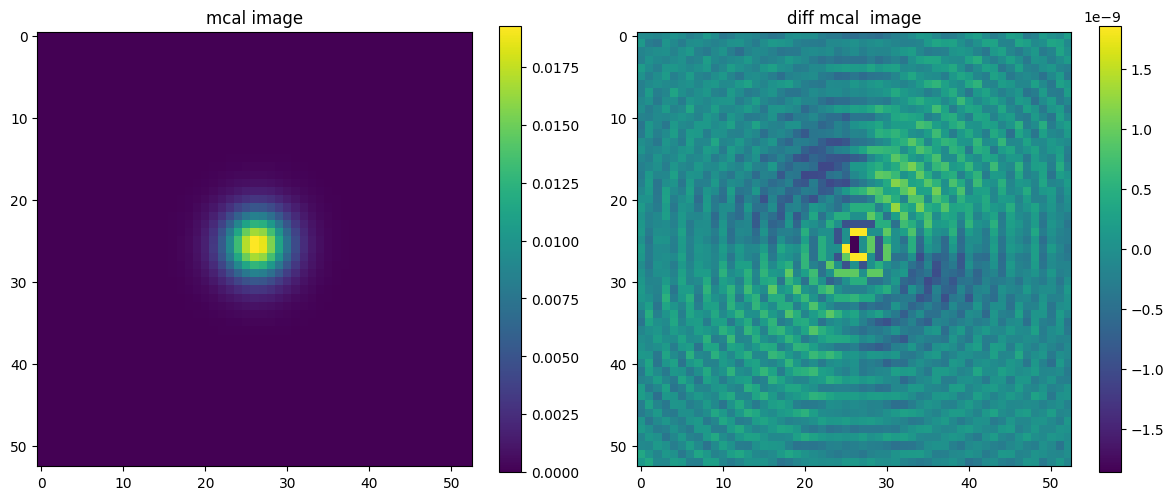

In [96]:
# mcal_image : here a deconvolution + a convolution has been applied
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_intermediates[5])
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("mcal image")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(jax_intermediates[5] - numpy_intermediates[5])
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("diff mcal  image")

plt.tight_layout()
plt.show()

# Comparing noise

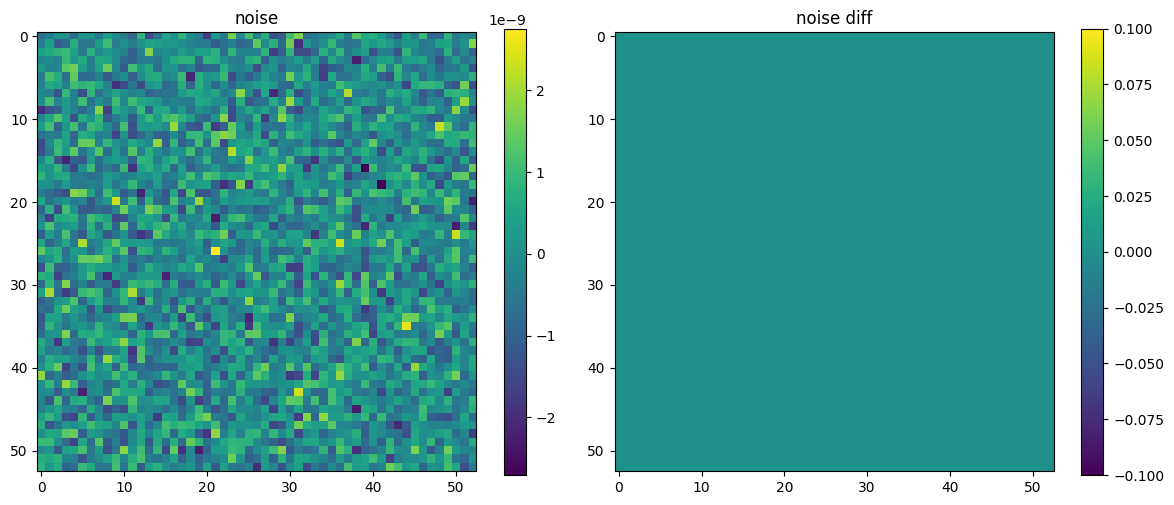

In [97]:
# compare noise
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_intermediates[2].image.array)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("noise")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(
    jax_intermediates[2].image.array - numpy_intermediates[2].image.array
)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("noise diff")

plt.tight_layout()
plt.show()

# Compare Deconvolution

In [98]:
jax_psf_deconvolved_im = jax_galsim.Convolve(
    [jax_intermediates[1], jax_intermediates[4]],
    gsparams=jax_galsim.GSParams(minimum_fft_size=53 * 8, maximum_fft_size=53 * 8),
)
numpy_psf_deconvolved_im = galsim.Convolve(
    [numpy_intermediates[1], numpy_intermediates[4]]
)

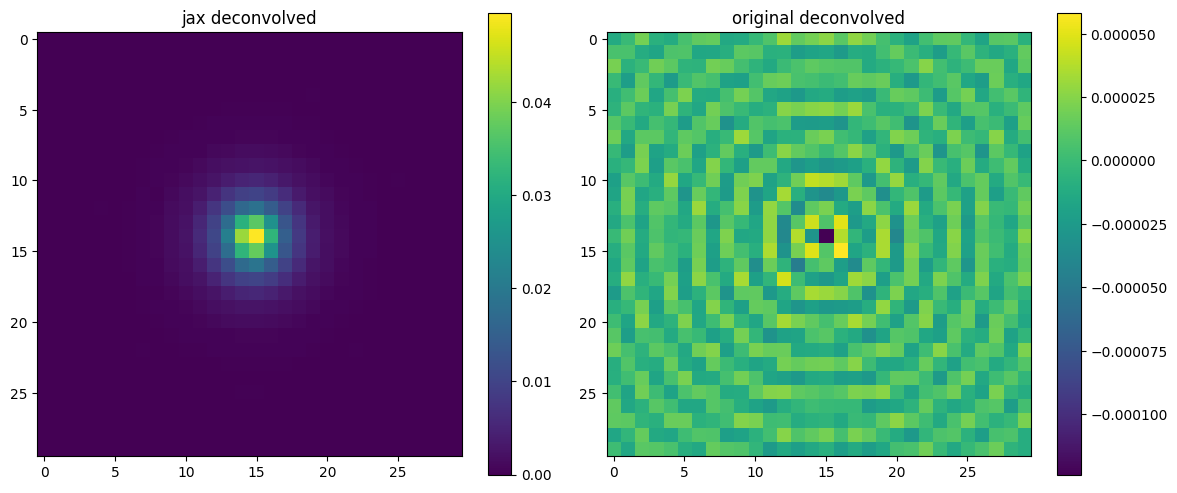

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_psf_deconvolved_im.drawImage(scale=0.2, nx=30, ny=30).array)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("jax deconvolved")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(
    jax_psf_deconvolved_im.drawImage(scale=0.2, nx=30, ny=30).array
    - numpy_psf_deconvolved_im.drawImage(scale=0.2, nx=30, ny=30).array
)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("original deconvolved")

plt.tight_layout()
plt.show()

# Now Compare after reconv psf

In [106]:
jax_image_ex2 = jax_galsim.Convolve(
    [jax_psf_deconvolved_im, jax_intermediates[7]],
    gsparams=jax_galsim.GSParams(minimum_fft_size=53 * 8, maximum_fft_size=53 * 8),
)
numpy_image_ex2 = galsim.Convolve([numpy_psf_deconvolved_im, numpy_intermediates[7]])

In [107]:
jax_psf_deconvolved_im

galsim.Convolution([galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-26, xmax=26, ymin=-26, ymax=26), array=
array([[3.40693077e-07, 3.75396894e-07, 4.12530881e-07, ...,
        4.36540006e-07, 3.95687437e-07, 3.57840207e-07],
       [3.74174135e-07, 4.14708438e-07, 4.59189465e-07, ...,
        4.85879298e-07, 4.37742131e-07, 3.94686253e-07],
       [4.10724994e-07, 4.58070645e-07, 5.09943675e-07, ...,
        5.39575865e-07, 4.85326098e-07, 4.36264770e-07],
       ...,
       [3.75209055e-07, 4.15854430e-07, 4.61532352e-07, ...,
        4.87706643e-07, 4.38426099e-07, 3.96964339e-07],
       [3.41272482e-07, 3.76544705e-07, 4.15455588e-07, ...,
        4.38453696e-07, 3.97309748e-07, 3.60540383e-07],
       [3.09538933e-07, 3.41027146e-07, 3.74926401e-07, ...,
        3.94865936e-07, 3.58036459e-07, 3.26984775e-07]]), wcs=galsim.PixelScale(1.0)), galsim.Lanczos(15, True, gsparams=galsim.GSParams(424,424,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)), g

In [108]:
numpy_psf_deconvolved_im

galsim.Convolution([galsim.InterpolatedImage(galsim.Image(bounds=galsim.BoundsI(xmin=-26, xmax=26, ymin=-26, ymax=26), array=
array([[3.40693077e-07, 3.75396894e-07, 4.12530881e-07, ...,
        4.36540006e-07, 3.95687437e-07, 3.57840207e-07],
       [3.74174135e-07, 4.14708438e-07, 4.59189465e-07, ...,
        4.85879298e-07, 4.37742131e-07, 3.94686253e-07],
       [4.10724994e-07, 4.58070645e-07, 5.09943675e-07, ...,
        5.39575865e-07, 4.85326098e-07, 4.36264770e-07],
       ...,
       [3.75209055e-07, 4.15854430e-07, 4.61532352e-07, ...,
        4.87706643e-07, 4.38426099e-07, 3.96964339e-07],
       [3.41272482e-07, 3.76544705e-07, 4.15455588e-07, ...,
        4.38453696e-07, 3.97309748e-07, 3.60540383e-07],
       [3.09538933e-07, 3.41027146e-07, 3.74926401e-07, ...,
        3.94865936e-07, 3.58036459e-07, 3.26984775e-07]]), wcs=galsim.JacobianWCS(0.2, 0.0, 0.0, 0.2)), galsim.Lanczos(15, True, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06

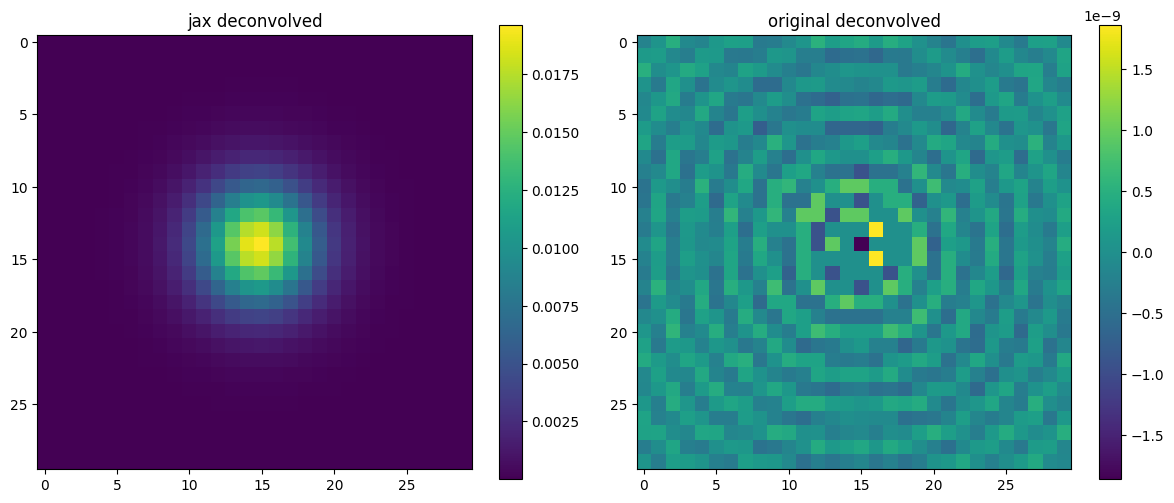

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: g[1]
im0 = axes[0].imshow(jax_image_ex2.drawImage(scale=0.2, nx=30, ny=30).array)
fig.colorbar(im0, ax=axes[0])
axes[0].set_title("jax deconvolved")

# Second subplot: g[1] - f[1]
im1 = axes[1].imshow(
    jax_image_ex2.drawImage(scale=0.2, nx=30, ny=30).array
    - numpy_image_ex2.drawImage(scale=0.2, nx=30, ny=30).array
)
fig.colorbar(im1, ax=axes[1])
axes[1].set_title("original deconvolved")

plt.tight_layout()
plt.show()

In [ ]:
def test_metacal_jax_vs_ngmix():
    nsims = 5

    rng = np.random.RandomState(seed=34132)
    seeds = rng.randint(size=nsims, low=1, high=2**29)
    res_p = []
    res_m = []
    res_p_ngmix = []
    res_m_ngmix = []
    for seed in seeds:
        res, res_ngmix, _, _, _, _, _ = _run_single_sim_pair_jax_and_ngmix(seed, 1e8)
        if res is not None:
            res_p.append(res[0])
            res_m.append(res[1])

            res_p_ngmix.append(res_ngmix[0])
            res_m_ngmix.append(res_ngmix[1])

            assert np.allclose(
                res[0].tolist(),
                res_ngmix[0].tolist(),
                atol=1e-6,
                rtol=1e-6,
                equal_nan=True,
            )
            assert np.allclose(
                res[1].tolist(),
                res_ngmix[1].tolist(),
                atol=1e-6,
                rtol=1e-6,
                equal_nan=True,
            )

    m, merr, c1, c1err, c2, c2err = estimate_m_and_c(
        np.concatenate(res_p),
        np.concatenate(res_m),
        0.02,
        jackknife=len(res_p),
    )

    m_ng, merr_ng, c1_ng, c1err_ng, c2_ng, c2err_ng = estimate_m_and_c(
        np.concatenate(res_p_ngmix),
        np.concatenate(res_m_ngmix),
        0.02,
        jackknife=len(res_p_ngmix),
    )

    print("JAX results:")
    print_m_c(m, merr, c1, c1err, c2, c2err)
    print("ngmix results:")
    print_m_c(m_ng, merr_ng, c1_ng, c1err_ng, c2_ng, c2err_ng)
    assert_m_c_ok(m, merr, c1, c1err, c2, c2err)

    assert np.allclose(m, m_ng, atol=1e-4)
    assert np.allclose(merr, merr_ng, atol=1e-6)
    assert np.allclose(c1err, c1err_ng, atol=1e-6)
    assert np.allclose(c1, c1_ng, atol=1e-6)
    assert np.allclose(c2err, c2err_ng, atol=1e-6)
    assert np.allclose(c2, c2_ng, atol=1e-6)

In [ ]:
test_metacal_jax_vs_ngmix()